In [9]:
# Used for unpickling byte stream of python objects on file system/disk
import pickle
# Used for decompressing .gzip files from file system/disk
import gzip
# Used for array operations
import numpy as np

## Load MNIST

In [10]:
# Opening and decompressing .gzip file
filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')

# Unpickling .pkl file saved as byte stream on disk to python objects
trainingData, validationData, testingData = pickle.load(f, encoding='latin1')
f.close()

# Training feature vectors and training target extracted from trainingData (target represented using one-hot format)
trainingTarget = np.array([1 if  trainingData[1][i] == t else 0  for i in range(len(trainingData[1])) for t in range(10)]).reshape(-1,10)
trainingData = trainingData[0]

# Validation feature vectors and validation target extracted from validationData
validationTarget = validationData[1]
validationData = validationData[0]

# Testing feature vectors and testing target extracted from testingData 
testingTarget = testingData[1]
testingData = testingData[0]

## Load USPS

In [11]:
# Used to open image in file system/disk
from PIL import Image
# Used to navigate to required directory in the file system
import os
# Used to convert image data to array
import numpy as np

In [12]:
USPSMat  = []
USPSTar  = []
curPath  = 'USPSdata/Numerals'
savedImg = []

# Navigate to the 10 folders containing images for 10 labels
for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            
            # Open image resize it, and save image array as well as labels in 2 lists
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

# Logistic Regression

In [13]:
# Used for performing kmeans clustering, while computing radial basis functions
from sklearn.cluster import KMeans
# Used when random functions are required
import random as rd
# Used for math operations
import math
# Used for array operations
import numpy as np
# Used for populating the confusion matrix
from sklearn.metrics import confusion_matrix

In [14]:
# Function to generate big sigma, which is a measure of how the input data spreads for each feature in the dataset
def GenerateBigSigma(Data, MuMatrix,IsSynthetic = False):
    
    #  Create empty matrix of size (f,f) where f is number of features in dataset    
    BigSigma    = np.zeros((len(Data[0]),len(Data[0])))
       
    # Ensures that variance is calculated only on 80% of input data used for training 
    TrainingLen = math.ceil(len(Data))   
    varVect     = []
    
    # Calculate variance for each of 41 features
    for i in range(0,len(Data[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[j][i])    
        varVect.append(np.var(vct))
    
    # The variances computed in the previous step are used to generate the (fxf) diagonal matrix big sigma
    for j in range(len(Data[0])):
        BigSigma[j][j] = varVect[j]
        
    # Value of big sigma multiplied with a large number to ensure its value stays significant
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

# This function does (x-mu)*(sigma^-1)(s-mu), where x is a single row from the data set and mu is one of the M cluster centroids and sigma^-1 is matrix inverse of big sigma
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

# Function to get e^(-0.5X), where X is the scalar value returned from the GetScalar function
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

# Function to generate the phi matrix, the matrix representation of the values of radial basis functions of the input with M centroids,
# which will be used to train the parameters in linear regression. RBFs are used to introduce non-linearity in the model.
def GetPhiMatrix(Data, MuMatrix, BigSigma):
    
           
    PHI = np.zeros((int(len(Data)),len(MuMatrix))) 
    
    # Get matrix inverse of big sigma
    BigSigInv = np.linalg.pinv(BigSigma)
    
    # Calculate value of the radial basis function for each sample in the input data set with each M centroid, for the big sigma calculated
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(len(Data))):
            PHI[R][C] = GetRadialBasisOut(Data[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

# Function to compute performance of the logistic regression model for given training/validation/test predicted labels and their corresponding targets
def GetErmsLogistic(VAL_TEST_OUT,ValDataAct):
    
    # Get label from one-hot representaion
    VAL_TEST_OUT = np.argmax(VAL_TEST_OUT, axis =1)
    ValDataAct = ValDataAct
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    
    # Computing accuracy by comparing test labels and predicted labels
    for i in range (0,len(VAL_TEST_OUT)):
        if(VAL_TEST_OUT[i] == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

In [15]:
# Function to simulate both linear and logistic regression models given datasets and hyper-parameters
def predictiveModel(mode, trainingData, trainingTarget, M=100, learningRate=0.001, La=0.005, BATCH_SIZE=1, EPOCHS=10):
    
    # If radial chosen, applies kmeans clustering, computes Mu and bigsigma to generate phi matrices
    if mode == 'Radial':
        kmeans = KMeans(n_clusters=M, random_state=0).fit(trainingData)
        Mu = kmeans.cluster_centers_
        BigSigma     = GenerateBigSigma(trainingData, Mu)
        TRAINING_PHI = GetPhiMatrix(trainingData, Mu, BigSigma)
        TEST_PHI     = GetPhiMatrix(testingData, Mu, BigSigma) 
        VAL_PHI      = GetPhiMatrix(validationData, Mu, BigSigma)

    # If radial is not chosen, generates phi matrices by adding a feature of ones to the feature vectors to accomodate bias
    else:
        TRAINING_PHI = np.append(np.ones((len(trainingData), 1)),trainingData, axis=1)
        TEST_PHI     = np.append(np.ones((len(testingData), 1)),testingData, axis=1)
        VAL_PHI      = np.append(np.ones((len(validationData), 1)),validationData, axis=1)
    
    np.random.seed = 0
    W_Now        = np.dot(np.random.rand(len(trainingData[0])+1,len(trainingTarget[0])),1)
    L_Erms_Val   = []
    L_Erms_TR    = []
    L_Erms_Test  = []
    
    # Runs mini-batch gradient descent with BATCH_SIZE over EPOCHS epochs
    for ep in range(EPOCHS):
        randIdx = [x for x in range(len(trainingTarget))]
        np.random.shuffle(randIdx)
        TRAINING_PHI = TRAINING_PHI[randIdx]
        trainingTarget = trainingTarget[randIdx]
        
        for start in range(0,int(len(trainingData)),BATCH_SIZE):
            end = start+BATCH_SIZE
            
            # Computing gradient of cross entropy error function w.r.t weights and updating weights to minimize cross entropy error
            expWTX = np.exp(np.matmul(TRAINING_PHI[start:end], W_Now))
            Delta_E_D     = -np.matmul(np.transpose(TRAINING_PHI[start:end]),(trainingTarget[start:end] - (expWTX/np.sum(expWTX, axis = 1, keepdims = True))))
            La_Delta_E_W  = np.dot(La,W_Now)
            Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
            Delta_W       = -np.dot(learningRate,Delta_E)
            W_T_Next      = W_Now + Delta_W
            W_Now         = W_T_Next
            expWTX = np.exp(np.matmul(TRAINING_PHI, W_Now))
            
            # -----------------TrainingData Accuracy---------------------#
            TR_TEST_OUT   = expWTX/np.sum(expWTX, axis = 1, keepdims = True)
            Erms_TR       = GetErmsLogistic(TR_TEST_OUT,np.argmax(trainingTarget, axis=1))
            L_Erms_TR.append(float(Erms_TR.split(',')[0]))

    print ('--------------Gradient Descent----------------\n')
    expWTX = np.exp(np.matmul(VAL_PHI, W_Now))
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = expWTX/np.sum(expWTX, axis = 1, keepdims = True)
    Erms_Val      = GetErmsLogistic(VAL_TEST_OUT,validationTarget)
    L_Erms_Val.append(float(Erms_Val.split(',')[0]))

    expWTX = np.exp(np.matmul(TEST_PHI, W_Now))
    #-----------------MNIST TestingData Accuracy---------------------#
    TEST_OUT      = expWTX/np.sum(expWTX, axis = 1, keepdims = True)
    Erms_Test = GetErmsLogistic(TEST_OUT,testingTarget)
    L_Erms_Test.append(float(Erms_Test.split(',')[0]))

    expWTX = np.exp(np.matmul(np.append(np.ones((len(USPSMat), 1)),USPSMat, axis=1), W_Now))
    #-----------------USPS TestingData Accuracy---------------------#
    USPS_TEST_OUT      = expWTX/np.sum(expWTX, axis = 1, keepdims = True)
    Erms_USPSTest = GetErmsLogistic(USPS_TEST_OUT,USPSTar)
    
    print ("Training accuracy        = " + str(np.around(L_Erms_TR[len(L_Erms_TR)-1],5)))
    print ("Validation accuracy      = " + str(np.around(L_Erms_Val[len(L_Erms_Val)-1],5)))
    print ("Testing accuracy         = " + str(np.around(L_Erms_Test[len(L_Erms_Test)-1],5)))
    print ("USPS Testing Accuracy    = " + str(np.around(float(Erms_USPSTest.split(',')[0]))),"\n")

    return L_Erms_TR, np.argmax(TEST_OUT, axis=1), np.argmax(USPS_TEST_OUT, axis=1)

In [16]:
# The commented section below was used to validate the logistic regression model using a grid search of the following hyper-parameters
# lr_list = [0.1, 0.03, 0.01, 0.005]
# lam_list = [0.3, 0.1, 0.03, 0.01]
# batch_list = [20, 50, 100]

# for learningRate in lr_list:
#     for La in lam_list:
#         for BATCH_SIZE in batch_list:
#             print("\nLearning rate: ", str(learningRate), "Lambda: ", str(La), "Batch size: ", str(BATCH_SIZE), "\n\n")
#             training, logMNISTPrediction, logUSPSPrediction = predictiveModel(None, trainingData, trainingTarget, 100, learningRate, La, BATCH_SIZE, EPOCHS=1)

# Training algorithm again on the best set of hyper-parameters (which give the best validation accuracy)
# to get the best training accuracy
training, logMNISTPrediction, logUSPSPrediction = predictiveModel(None, trainingData, trainingTarget, M=100, learningRate=0.01, La=0.01, BATCH_SIZE=20, EPOCHS=1)
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(testingTarget, logMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(USPSTar, logUSPSPrediction))

--------------Gradient Descent----------------

Training accuracy        = 90.028
Validation accuracy      = 90.51
Testing accuracy         = 90.11
USPS Testing Accuracy    = 33.0 


MNIST Confusion Matrix: 

 [[ 966    0    2    2    1    4    3    1    1    0]
 [   0 1114    2    2    1    3    3    1    9    0]
 [  16   14  915    9   19    0    6   14   36    3]
 [   4    2   22  898    5   39    1   11   21    7]
 [   2    3    3    0  942    0   10    1    8   13]
 [  13    3    7   35   21  764   12    5   29    3]
 [  19    3    8    2   32   20  869    2    3    0]
 [   3   16   29    5   18    1    0  938    1   17]
 [  10   13    6   18   25   34   10    9  845    4]
 [  14    8    0    8  170    7    0   34    8  760]]

USPS Confusion Matrix: 

 [[ 530   11  167   94  180  287  101  109  148  373]
 [ 131  336  197  224  400  104   20  430  133   25]
 [ 184   32 1170  140   66  173   69   78   59   28]
 [ 114   19  205 1102   37  341    6   90   58   28]
 [  32   94   41   6

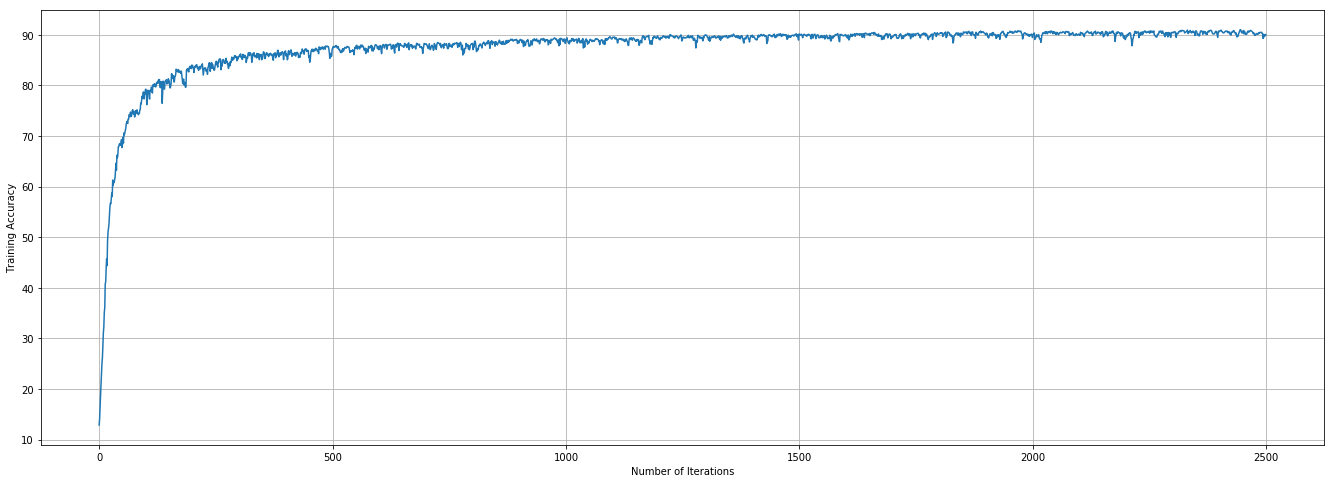

In [18]:
# The matplotlib package is used for plotting graphs
import matplotlib
import matplotlib.pyplot as plt 
# Outputs training accuracy for each iteration of gradient descent
fig2, ax2=plt.subplots(figsize=(23,8))
ax2.plot( training)
ax2.set(xlabel='Number of Iterations', ylabel='Training Accuracy')
ax2.grid()
plt.show()

# SVM

In [19]:
import numpy as np
from sklearn.svm import SVC

In [20]:
# SVM classifier from scikit learn
SVMclassifier = SVC(kernel='rbf')#, C=1, gamma = 0.05);
# Picking 10,000 random samples from dataset
randIdx = [x for x in range(len(trainingData))]
np.random.shuffle(randIdx)
SVMclassifier.fit(trainingData[randIdx[:10000]], np.argmax(trainingTarget[randIdx[:10000]], axis=1))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
svmValPrediction = SVMclassifier.predict(validationData)
svmMNISTPrediction = SVMclassifier.predict(testingData)
svmUSPSPrediction = SVMclassifier.predict(USPSMat)

print ('---------------SVM----------------\n')
print('Validation accuracy       = ', np.mean(svmValPrediction == validationTarget)*100)
print('MNIST Testing accuracy    = ', np.mean(svmMNISTPrediction == testingTarget)*100)
print('USPS Testing accuracy     = ', np.mean(svmUSPSPrediction == USPSTar)*100,"\n")
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(testingTarget, svmMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(USPSTar, svmUSPSPrediction))

---------------SVM----------------

Validation accuracy       =  92.71000000000001
MNIST Testing accuracy    =  92.31
USPS Testing accuracy     =  37.25186259312966 


MNIST Confusion Matrix: 

 [[ 961    0    1    0    1    6    7    1    3    0]
 [   0 1116    3    2    0    2    4    0    8    0]
 [  11    3  926   11   16    2   20   14   29    0]
 [   5    4   18  912    0   24    2   14   25    6]
 [   1    3    6    0  919    1    9    1    3   39]
 [   9    9    5   37    8  791   17    3    8    5]
 [  12    3    4    0    7   17  913    0    2    0]
 [   1   23   23    1   13    1    0  933    5   28]
 [   6    8   10   14   11   28   12   11  866    8]
 [  15    9    4   10   46    9    0   15    7  894]]

USPS Confusion Matrix: 

 [[ 586    3  422   19  358  240   78   37   14  243]
 [ 111  512  192  105  478  195   29  339   23   16]
 [ 174   33 1230   54   53  261   65   80   34   15]
 [  93    9  169  976   26  545   15  102   40   25]
 [  19  118   58   13 1201  281   1

# Random Forest

In [22]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [23]:
#RandomForest Classifier from scikit learn
RFclassifier = RandomForestClassifier(n_estimators=200, n_jobs=-1);

# RFclassifier.fit(trainingData[randIdx[:10000]], np.argmax(trainingTarget[randIdx[:10000]], axis=1))
RFclassifier.fit(trainingData, np.argmax(trainingTarget, axis=1))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
rfValPrediction = RFclassifier.predict(validationData)
rfMNISTPrediction = RFclassifier.predict(testingData)
rfUSPSPrediction = RFclassifier.predict(USPSMat)

print ('---------------Random Forest----------------\n')
print('Validation accuracy    = ', np.mean(rfValPrediction == validationTarget)*100)
print('MNIST Testing accuracy = ', np.mean(rfMNISTPrediction == testingTarget)*100)
print('USPS Testing accuracy  = ', np.mean(rfUSPSPrediction == USPSTar)*100,"\n")
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(testingTarget, rfMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(USPSTar, rfUSPSPrediction))

---------------Random Forest----------------

Validation accuracy    =  97.24000000000001
MNIST Testing accuracy =  97.04
USPS Testing accuracy  =  40.08700435021751 


MNIST Confusion Matrix: 

 [[ 970    0    0    0    0    2    3    1    3    1]
 [   0 1121    3    3    1    2    2    1    2    0]
 [   6    0 1000    5    2    0    3    9    7    0]
 [   0    0    9  975    0    7    0    9    8    2]
 [   1    0    1    0  953    0    5    0    2   20]
 [   2    0    1   12    3  861    4    1    5    3]
 [   6    3    0    0    2    3  940    0    4    0]
 [   1    3   17    2    2    0    0  990    3   10]
 [   3    0    6    7    4    6    3    5  931    9]
 [   5    5    2   11   10    2    1    4    6  963]]

USPS Confusion Matrix: 

 [[ 643   11  262   60  435  163   80  107    1  238]
 [  58  591  118  102   57   85   22  950   17    0]
 [  99   26 1287   78   49  186   23  244    5    2]
 [  36    6   92 1274   54  350    4  166    4   14]
 [  12  216   57   27 1049  196   

# Neural Network

In [25]:
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

C:\Users\Dan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [26]:
#DNN
num_classes = len(trainingTarget[0])
DNNclassifier = Sequential()
DNNclassifier.add(Dense(units=200, activation='relu', input_shape=(len(trainingData[0]),)))
DNNclassifier.add(Dropout(0.2))
DNNclassifier.add(Dense(units=200, activation='relu'))
DNNclassifier.add(Dropout(0.2))
# DNNclassifier.add(Dense(units=200, activation='relu'))
# DNNclassifier.add(Dropout(0.2))
DNNclassifier.add(Dense(units=num_classes, activation='softmax'))
DNNclassifier.compile(optimizer='Adamax', loss='categorical_crossentropy',metrics=['accuracy'])
history = DNNclassifier.fit(trainingData, trainingTarget, batch_size=128, epochs=100,
verbose=False,validation_data=(validationData, keras.utils.to_categorical(validationTarget, num_classes)))

In [27]:
loss,valAccuracy = DNNclassifier.evaluate(validationData, keras.utils.to_categorical(validationTarget, num_classes), verbose=False)
loss,testAccuracy = DNNclassifier.evaluate(testingData, keras.utils.to_categorical(testingTarget, num_classes), verbose=False)
loss,testUSPSAccuracy = DNNclassifier.evaluate(np.array(USPSMat), keras.utils.to_categorical(USPSTar, num_classes), verbose=False)
dnnMNISTPrediction = np.argmax(DNNclassifier.predict(testingData), axis=1)
dnnUSPSPrediction = np.argmax(DNNclassifier.predict(np.array(USPSMat)), axis=1)

print ('---------------DNN----------------\n')
print('Validation accuracy    = ', valAccuracy*100)
print('MNIST Testing accuracy = ', testAccuracy*100)
print('USPS Testing accuracy  = ', testUSPSAccuracy*100,'"\n"')
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(testingTarget, dnnMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(USPSTar, dnnUSPSPrediction))

---------------DNN----------------

Validation accuracy    =  98.32
MNIST Testing accuracy =  98.29
USPS Testing accuracy  =  47.88239411940795 "
"

MNIST Confusion Matrix: 

 [[ 970    0    1    0    0    1    3    1    3    1]
 [   0 1126    0    1    0    1    2    0    5    0]
 [   0    1 1016    5    2    0    0    6    2    0]
 [   0    0    2  993    0    7    0    5    1    2]
 [   0    1    1    0  964    0    4    2    0   10]
 [   1    0    0    3    1  877    5    1    2    2]
 [   5    2    1    1    3    4  941    0    1    0]
 [   1    3   10    3    1    0    0 1005    2    3]
 [   4    0    2    4    3    1    0    4  953    3]
 [   2    4    0    2    8    1    0    5    3  984]]

USPS Confusion Matrix: 

 [[ 520    2  131   62  153  201  326  236   69  300]
 [  17  439  487  111  292   95   26  382   92   59]
 [  20   12 1555   61   21   96  134   52   46    2]
 [   8    7  195 1425    4  263   27   38   25    8]
 [   7   25   66   18 1156  111   45  343  186   43]
 

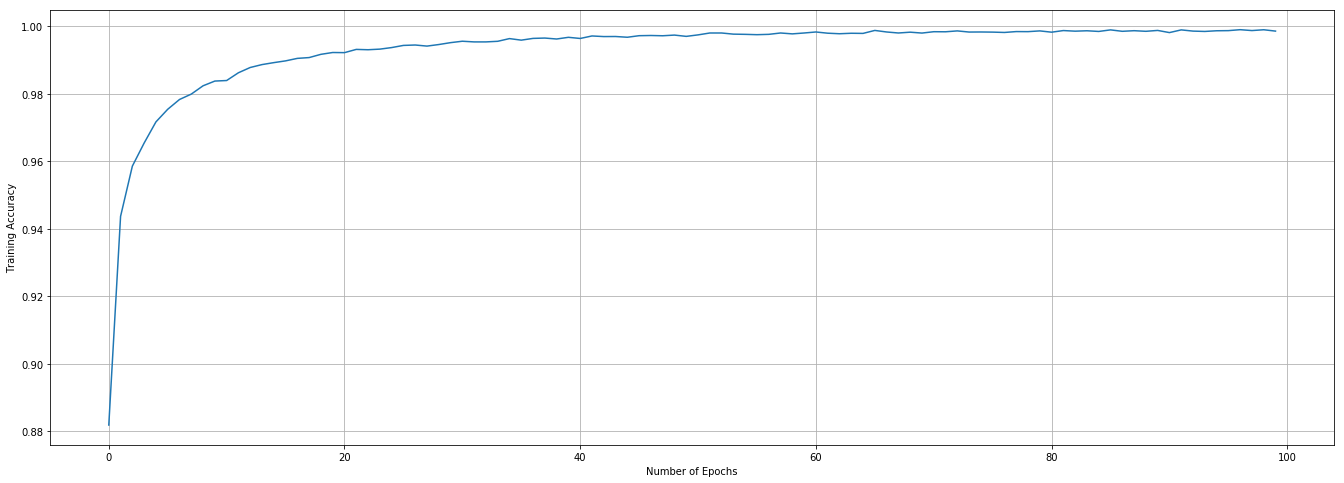

In [28]:
# The matplotlib package is used for plotting graphs
import matplotlib
import matplotlib.pyplot as plt 
# Outputs training accuracy and loss against epochs
fig2, ax2=plt.subplots(figsize=(23,8))
ax2.plot(history.history['acc'])
ax2.set(xlabel='Number of Epochs', ylabel='Training Accuracy')
ax2.grid()
plt.show()

In [29]:
#CNN
CNNclassifier = Sequential()
CNNclassifier.add(Conv2D(20, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
CNNclassifier.add(MaxPooling2D(pool_size=(2, 2)))
CNNclassifier.add(Conv2D(20, (3, 3), activation='relu'))
CNNclassifier.add(MaxPooling2D(pool_size=(2, 2)))
CNNclassifier.add(Flatten())
CNNclassifier.add(Dense(units=200, activation='relu'))
CNNclassifier.add(Dropout(0.2))
CNNclassifier.add(Dense(units=200, activation='relu'))
CNNclassifier.add(Dropout(0.2))
CNNclassifier.add(Dense(units=num_classes, activation='softmax'))
CNNclassifier.compile(optimizer='Adamax', loss='categorical_crossentropy',metrics=['accuracy'])
history = CNNclassifier.fit(trainingData.reshape(-1, 28, 28, 1), trainingTarget, batch_size=128, epochs=10,
verbose=True,validation_data=(validationData.reshape(-1, 28, 28, 1), keras.utils.to_categorical(validationTarget, num_classes)))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 44s 884us/step - loss: 0.3622 - acc: 0.8868 - val_loss: 0.0953 - val_acc: 0.9718
Epoch 2/10
50000/50000 [==============================] - 41s 820us/step - loss: 0.1075 - acc: 0.9668 - val_loss: 0.0609 - val_acc: 0.9826
Epoch 3/10
50000/50000 [==============================] - 38s 762us/step - loss: 0.0757 - acc: 0.9766 - val_loss: 0.0517 - val_acc: 0.9850
Epoch 4/10
50000/50000 [==============================] - 39s 771us/step - loss: 0.0589 - acc: 0.9819 - val_loss: 0.0455 - val_acc: 0.9869
Epoch 5/10
50000/50000 [==============================] - 39s 786us/step - loss: 0.0501 - acc: 0.9843 - val_loss: 0.0426 - val_acc: 0.9883
Epoch 6/10
50000/50000 [==============================] - 40s 794us/step - loss: 0.0423 - acc: 0.9871 - val_loss: 0.0453 - val_acc: 0.9867
Epoch 7/10
50000/50000 [==============================] - 40s 810us/step - loss: 0.0373 - acc: 0.9884 - val_loss: 0.

In [30]:
loss,valAccuracy = CNNclassifier.evaluate(validationData.reshape(-1, 28, 28, 1), keras.utils.to_categorical(validationTarget, num_classes), verbose=False)
loss,testAccuracy = CNNclassifier.evaluate(testingData.reshape(-1, 28, 28, 1), keras.utils.to_categorical(testingTarget, num_classes), verbose=False)
loss,testUSPSAccuracy = CNNclassifier.evaluate(np.array(USPSMat).reshape(-1, 28, 28, 1), keras.utils.to_categorical(USPSTar, num_classes), verbose=False)
cnnMNISTPrediction = np.argmax(CNNclassifier.predict(testingData.reshape(-1, 28, 28, 1)), axis=1)
cnnUSPSPrediction = np.argmax(CNNclassifier.predict(np.array(USPSMat).reshape(-1, 28, 28, 1)), axis=1)

print ('---------------CNN----------------\n')
print('Validation accuracy    = ', valAccuracy*100)
print('MNIST Testing accuracy = ', testAccuracy*100)
print('USPS Testing accuracy  = ', testUSPSAccuracy*100,"\n")
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(testingTarget, cnnMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(USPSTar, cnnUSPSPrediction))

---------------CNN----------------

Validation accuracy    =  98.97
MNIST Testing accuracy =  99.1
USPS Testing accuracy  =  64.48322415971786 


MNIST Confusion Matrix: 

 [[ 976    0    0    0    0    0    1    1    2    0]
 [   0 1133    1    0    0    0    1    0    0    0]
 [   2    1 1023    1    1    0    0    4    0    0]
 [   0    0    2 1003    0    3    0    0    2    0]
 [   0    0    0    0  978    0    0    0    1    3]
 [   2    0    1    6    0  880    1    0    2    0]
 [   4    2    0    0    4    3  944    0    1    0]
 [   0    4    4    1    0    0    0 1018    1    0]
 [   1    0    1    1    0    0    0    1  969    1]
 [   1    3    0    1    5    3    0    4    6  986]]

USPS Confusion Matrix: 

 [[ 661    2   59   21  359   12   83   13   77  713]
 [ 102  955   57   33  651   11   38  105   30   18]
 [  39   12 1671   85   27   45   30   18   67    5]
 [   2    3   35 1781    2  134    2    9   30    2]
 [   1   56   10    8 1501    9    2  227  178    8]
 [  

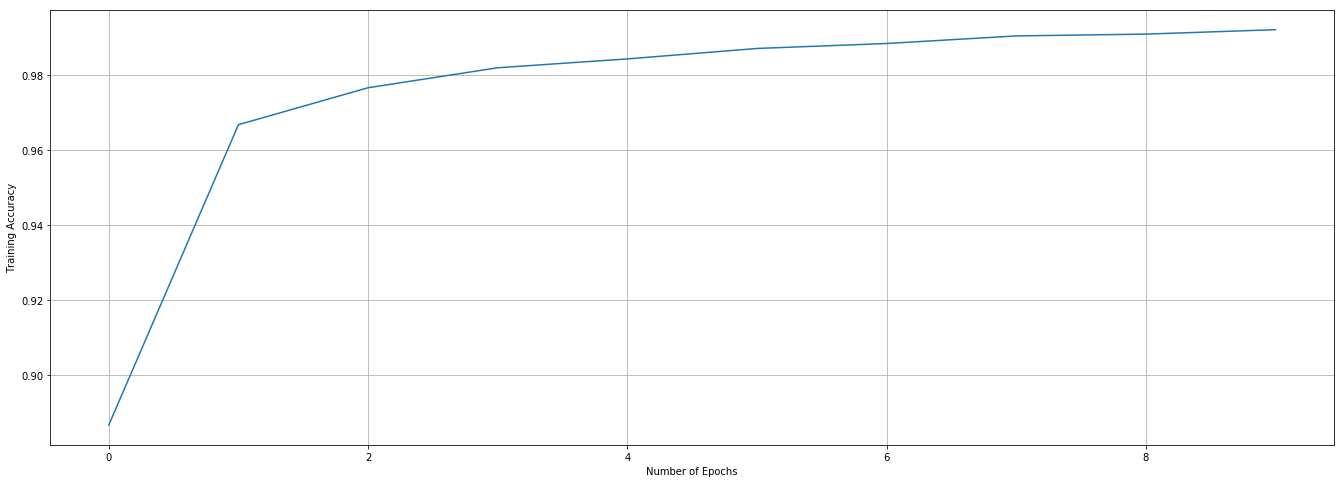

In [31]:
# The matplotlib package is used for plotting graphs
import matplotlib
import matplotlib.pyplot as plt 
# Outputs training accuracy and loss against epochs
fig2, ax2=plt.subplots(figsize=(23,8))
ax2.plot(history.history['acc'])
ax2.set(xlabel='Number of Epochs', ylabel='Training Accuracy')
ax2.grid()
plt.show()

# Ensemble classifier

In [34]:
from scipy import stats
# Appending all predictions into a single array
appendedPredictions = np.append(np.append(np.append(logMNISTPrediction.reshape(len(testingTarget),1), 
                                                    svmMNISTPrediction.reshape(len(testingTarget),1), axis=1),
                                          np.append(rfMNISTPrediction.reshape(len(testingTarget),1), 
                                                    dnnMNISTPrediction.reshape(len(testingTarget),1), axis=1),axis=1), 
                                cnnMNISTPrediction.reshape(len(testingTarget),1), axis=1)

appendedUSPSPredictions = np.append(np.append(np.append(logUSPSPrediction.reshape(len(USPSTar),1), 
                                                    svmUSPSPrediction.reshape(len(USPSTar),1), axis=1),
                                          np.append(rfUSPSPrediction.reshape(len(USPSTar),1), 
                                                    dnnUSPSPrediction.reshape(len(USPSTar),1), axis=1),axis=1), 
                                cnnUSPSPrediction.reshape(len(USPSTar),1), axis=1)

In [35]:
# Computing mode of predictions of each classifier to get majority voting
ensemblePrediction, freq = stats.mode(np.transpose(appendedPredictions))
ensembleUSPSPrediction, freq = stats.mode(np.transpose(appendedUSPSPredictions))

print("Ensemble MNIST Accuracy = ", np.mean(ensemblePrediction == testingTarget)*100)
print("Ensemble USPS Accuracy  = ", np.mean(ensembleUSPSPrediction == np.array(USPSTar))*100)
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(ensemblePrediction.flatten(), cnnMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(ensembleUSPSPrediction.flatten(), cnnUSPSPrediction))

Ensemble MNIST Accuracy =  97.52
Ensemble USPS Accuracy  =  46.31231561578079

MNIST Confusion Matrix: 

 [[ 982    0    5    0    2    1    5    1    3    7]
 [   0 1133    0    1    0    0    2    5    2    2]
 [   1    1 1010    4    4    1    0   12    3    0]
 [   0    2    2  993    0    4    0    0    4   10]
 [   0    0    2    0  963    2    1    1    8   10]
 [   0    1    1    2    0  872    5    0    9    1]
 [   2    2    1    0    6    4  933    0    5    0]
 [   0    2    7    8    0    2    0 1004    3    1]
 [   1    2    4    4    2    2    1    0  942    2]
 [   0    0    0    1   11    1    0    5    5  957]]

USPS Confusion Matrix: 

 [[ 711   33  103   53   87  141  187   77   70   60]
 [   0  668   63  167   89   18    5  205  114   35]
 [  28  123 1806  247  160  100  248  215  247  212]
 [   6   51   70 1809  111   88   15  220  150  117]
 [   9   90   37   25 1869   26   62   82  133  266]
 [  39   90  112  286  169 2073  263  256  541  110]
 [  20    5   33  